In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from data.constants import (
    DEFAULT_REFLACX_BOX_COORD_COLS,
    DEFAULT_REFLACX_BOX_FIX_COLS,
    REFLACX_ALL_LABEL_COLS,
    DEFAULT_REFLACX_LABEL_COLS,
    DEFAULT_REFLACX_PATH_COLS,
    DEFAULT_REFLACX_REPETITIVE_LABEL_MAP,
)
import seaborn as sns
from ast import List
import json
from typing import Callable
from data.paths import MIMIC_EYE_PATH
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import numpy as np

class FixationPoint():
    def __init__(self, x, y, start_t, end_t) -> None:
        self.x = x 
        self.y = y
        self.start_t = start_t
        self.end_t = end_t 

    def get_duration(self,):
        return self.end_t - self.start_t

class LesionBB():
    def __init__(self, minx, miny, maxx, maxy, lesion) -> None:
        self.minx = minx
        self.miny = miny
        self.maxx = maxx
        self.maxy = maxy
        self.lesion = lesion

        self.__init_ellipse()

    def __init_ellipse(self):
        self.h = (self.minx+self.maxx) / 2
        self.k = (self.miny+self.maxy) / 2
        self.a = np.abs((self.maxx-self.minx) / 2)
        self.b = np.abs((self.maxy -self.miny) /2)

    def fall_in_on_ellipse(self, x, y):
        # (x-h)^2/a^2 + (y-k)^2/b^2 <= 1
        p = ((x - self.h)**2 / self.a**2) + ((y - self.k)**2 / self.b**2)
        return p <= 1

def fixation_in_silent(fixation: FixationPoint, report_starting_time: float):
    return fixation.start_t < report_starting_time

def get_fixations_timepoint(fixations: list[FixationPoint], report_starting_time: float,  mode: str="silent"):
    if mode == "silent":
        return [f  for  f in fixations if  fixation_in_silent( fixation= f, report_starting_time=report_starting_time)]
    elif mode == 'reporting':
        return  [f  for  f in fixations if not fixation_in_silent( fixation= f, report_starting_time=report_starting_time)]
    else:
        raise("Unsupported mode")
    
class Scanpaths():
    def __init__(self, fixations: list[FixationPoint], report_starting_time: float) -> None:
        self.fixations: list[FixationPoint] = fixations
        self.report_starting_time: float  = report_starting_time
        self.full_duration: float = self.fixations[-1].end_t

    def get_silent_fixations(self,):
        return get_fixations_timepoint(fixations=self.fixations, report_starting_time= self.report_starting_time, mode="silent")

    def get_reporting_fixations(self,): 
        return get_fixations_timepoint(fixations=self.fixations, report_starting_time= self.report_starting_time, mode="reporting")

    def get_silent_duration(self,):
        return self.report_starting_time

    def get_reporting_duration(self,):
        return self.full_duration - self.report_starting_time

def fixation_duration_in_bbs(fixations: list[FixationPoint], bbs: list[LesionBB]) -> dict[LesionBB, list[FixationPoint]]:
    '''
    fixations: []
    output:
    {
       'lesion_name': duration 
    }
    '''
    lesion_fixations_dict: dict[LesionBB, list[FixationPoint]] = { b:[]for b in bbs }


    for bb in bbs:
        for fix in fixations:
            if bb.fall_in_on_ellipse(x=fix.x, y=fix.y):
                lesion_fixations_dict[bb].append(fix)

    return lesion_fixations_dict


# do time and percentage.

def get_fixation_duration_on_lesions(scanpaths:Scanpaths, lesion_bbs: list[LesionBB]):
    # lesion_fixations_dict = fixation_duration_in_bbs(fixations=scanpaths.fixations, bbs=lesion_bbs)
    # transform to lesion: time.

    lesion_fixation_time={'full': { 'duration': scanpaths.full_duration  }, 'silent': { 'duration': scanpaths.get_silent_duration()}, 'reporting':{ 'duration': scanpaths.get_reporting_duration()}}

    for f in scanpaths.fixations:
        for lesion in REFLACX_ALL_LABEL_COLS:
            # get the bounding boxes:
            fall_in_this_lesion = any([b.fall_in_on_ellipse(f.x, f.y) for b in lesion_bbs if b.lesion == lesion]) 

            if fall_in_this_lesion:
                dur = f.get_duration()
                if not lesion in lesion_fixation_time['full']:
                    lesion_fixation_time['full'][lesion] = 0
                lesion_fixation_time['full'][lesion]+= dur
                
                if fixation_in_silent(fixation=f, report_starting_time= scanpaths.report_starting_time):
                    if not lesion in lesion_fixation_time['silent']:
                        lesion_fixation_time['silent'][lesion] = 0
                    lesion_fixation_time['silent'][lesion]+= dur
                else:
                    if not lesion in lesion_fixation_time['reporting']:
                        lesion_fixation_time['reporting'][lesion] = 0
                    lesion_fixation_time['reporting'][lesion]+= dur


    # for k, v in lesion_fixations_dict.items():
    #     # init the lesion
    #     if not k.lesion in lesion_fixation_time['full']:
    #         lesion_fixation_time['full'][lesion] = 0

    #     for f in v:
    #         dur =f.get_duration()
    #         lesion_fixation_time['full'][lesion] += dur 

    #         if fixation_in_silent(fixation=f, report_starting_time= scanpaths.report_starting_time):
    #             if not k.lesion in lesion_fixation_time['silent']:
    #                 lesion_fixation_time['silent'][k.lesion] = 0
    #             lesion_fixation_time['silent'][k.lesion]+= dur
    #         else:
    #             if not k.lesion in lesion_fixation_time['reporting']:
    #                 lesion_fixation_time['reporting'][k.lesion] = 0
    #             lesion_fixation_time['reporting'][k.lesion]+= dur

    return lesion_fixation_time

def generate_bboxes_df(lesion_df):    
    boxes_df = lesion_df[DEFAULT_REFLACX_BOX_FIX_COLS]

    # relabel repetitive columns.
    for k in DEFAULT_REFLACX_REPETITIVE_LABEL_MAP.keys():
        boxes_df.loc[:, k] = lesion_df[
            [l for l in DEFAULT_REFLACX_REPETITIVE_LABEL_MAP[k] if l in lesion_df.columns]
        ].any(axis=1)

    # filtering out the diseases not in the label_cols
    boxes_df = boxes_df[boxes_df[DEFAULT_REFLACX_LABEL_COLS].any(axis=1)]
    label_df = boxes_df.loc[:, DEFAULT_REFLACX_LABEL_COLS].reset_index(drop=True)

    labels = [
        list(label_df.loc[i, label_df.any()].index) for i in range(len(label_df))
    ]

    boxes_df["label"] = labels

    new_df_list = []

    if len(boxes_df) > 0:
        for _, instance in boxes_df.iterrows():
            for l in instance["label"]:
                new_df_list.append(
                    {
                        "xmin": instance["xmin"],
                        "ymin": instance["ymin"],
                        "xmax": instance["xmax"],
                        "ymax": instance["ymax"],
                        "label": l,
                    }
                )

    return pd.DataFrame(
        new_df_list, columns=["xmin", "ymin", "xmax", "ymax", "label"]
    )

In [3]:
df = pd.read_csv(os.path.join('./spreadsheets/', "reflacx_eye.csv"), index_col =0)

In [4]:
for p_col in DEFAULT_REFLACX_PATH_COLS:
    if p_col in df.columns:
        if p_col == "bbox_paths":

            def apply_bbox_paths_transform(input_paths_str: str) -> List[str]:
                input_paths_list: List[str] = json.loads(input_paths_str)
                replaced_path_list: List[str] = [
                    p.replace("{XAMI_MIMIC_PATH}", MIMIC_EYE_PATH)
                    for p in input_paths_list
                ]
                return replaced_path_list

            apply_fn: Callable[
                [str], List[str]
            ] = lambda x: apply_bbox_paths_transform(x)

        else:
            apply_fn: Callable[[str], str] = lambda x: str(
                Path(x.replace("{XAMI_MIMIC_PATH}", MIMIC_EYE_PATH))
            )

        df[p_col] = df[p_col].apply(apply_fn)

In [5]:
lesion_dur = []

for _, isntance in df.iterrows():
    fixation_df = pd.read_csv(isntance['fixation_path'])
    utterance_path = os.path.join(
            os.path.dirname(isntance["fixation_path"]),
            "timestamps_transcription.csv",
        )
    utterance_df = pd.read_csv(utterance_path)
    report_starting_time = utterance_df.iloc[0]["timestamp_start_word"]
    fixations= [ FixationPoint(x=f["x_position"], y=f['y_position'], start_t=f['timestamp_start_fixation'], end_t=f['timestamp_end_fixation']) for _, f in  fixation_df.iterrows()]
    scanpaths = Scanpaths(fixations=fixations, report_starting_time= report_starting_time)
    lesion_df = pd.read_csv(isntance["bbox_path"])
    bboxes_df = generate_bboxes_df(lesion_df)
    lesion_bbs = [LesionBB(minx=b['xmin'], miny=b['ymin'], maxx=b['xmax'], maxy=b['ymax'], lesion=b['label']) for  _, b in bboxes_df.iterrows()]
    lesion_dur.append(get_fixation_duration_on_lesions(scanpaths=scanpaths, lesion_bbs=lesion_bbs))

In [6]:
lesion_dur[:5]

[{'full': {'duration': 26.411,
   'Enlarged cardiac silhouette': 7.763999999999986},
  'silent': {'duration': 7.05,
   'Enlarged cardiac silhouette': 0.38099999999999934},
  'reporting': {'duration': 19.361,
   'Enlarged cardiac silhouette': 7.382999999999987}},
 {'full': {'duration': 33.74,
   'Enlarged cardiac silhouette': 8.847999999999995},
  'silent': {'duration': 7.7,
   'Enlarged cardiac silhouette': 1.5569999999999997},
  'reporting': {'duration': 26.040000000000003,
   'Enlarged cardiac silhouette': 7.290999999999996}},
 {'full': {'duration': 96.206,
   'Enlarged cardiac silhouette': 14.998999999999977},
  'silent': {'duration': 10.41, 'Enlarged cardiac silhouette': 0.927},
  'reporting': {'duration': 85.796,
   'Enlarged cardiac silhouette': 14.071999999999978}},
 {'full': {'duration': 128.95},
  'silent': {'duration': 13.95},
  'reporting': {'duration': 114.99999999999999}},
 {'full': {'duration': 36.983,
   'Enlarged cardiac silhouette': 9.233999999999998},
  'silent': {'du

In [7]:
def boxplot_generate(lesion_dur, mode="full"):
    each_lesion_duration_list = { l:[] for l in DEFAULT_REFLACX_LABEL_COLS}
    each_lesion_duration_percentage_list = { l:[] for l in DEFAULT_REFLACX_LABEL_COLS} 
    for lesion in DEFAULT_REFLACX_LABEL_COLS:
        for d in lesion_dur:
            if lesion in d[mode]:
                each_lesion_duration_list[lesion].append(d[mode][lesion])
                each_lesion_duration_percentage_list[lesion].append(d[mode][lesion]/d[mode]['duration'])

    plt.figure(figsize=(12, 5))
    plt.boxplot([v for v in each_lesion_duration_list.values()], labels=list(each_lesion_duration_list.keys()))
    plt.xlabel("Lesions")
    plt.ylabel("Duration in Bounding Boxes (sec)")
    plt.show()


    plt.figure(figsize=(12, 5))
    plt.boxplot([v*100 for v in each_lesion_duration_percentage_list.values()], labels=list(each_lesion_duration_percentage_list.keys()))
    plt.xlabel("Lesions")
    plt.ylabel("Percentage of Duration in Bounding Boxes (%)")
    plt.show()


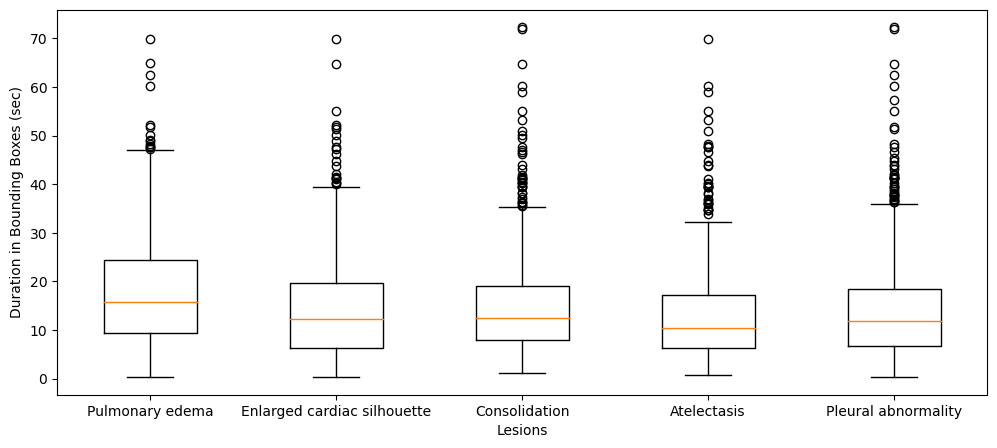

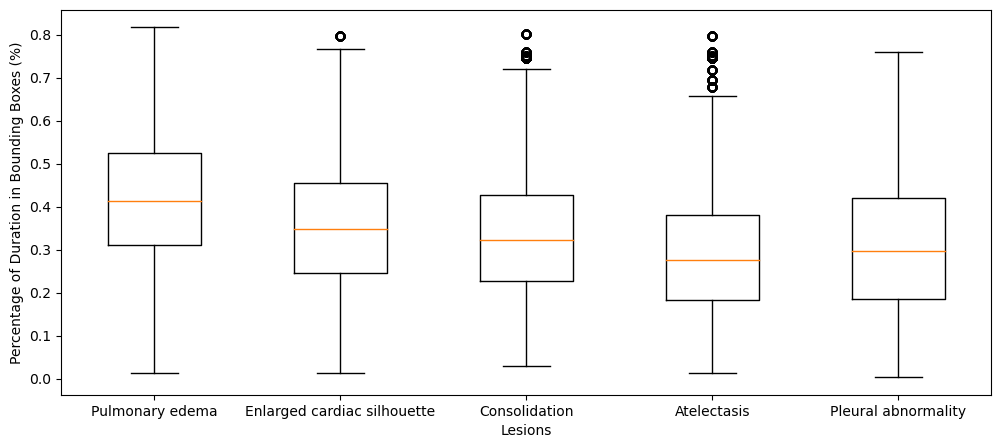

In [8]:
boxplot_generate(lesion_dur=lesion_dur, mode="full")

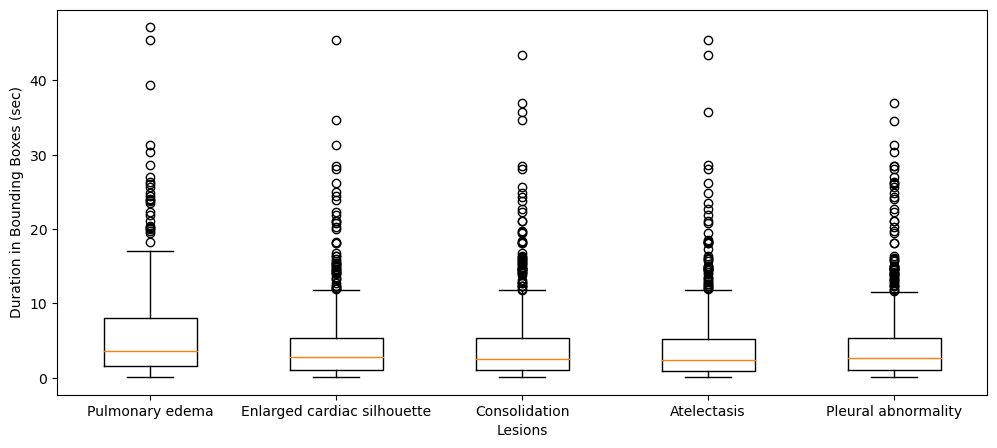

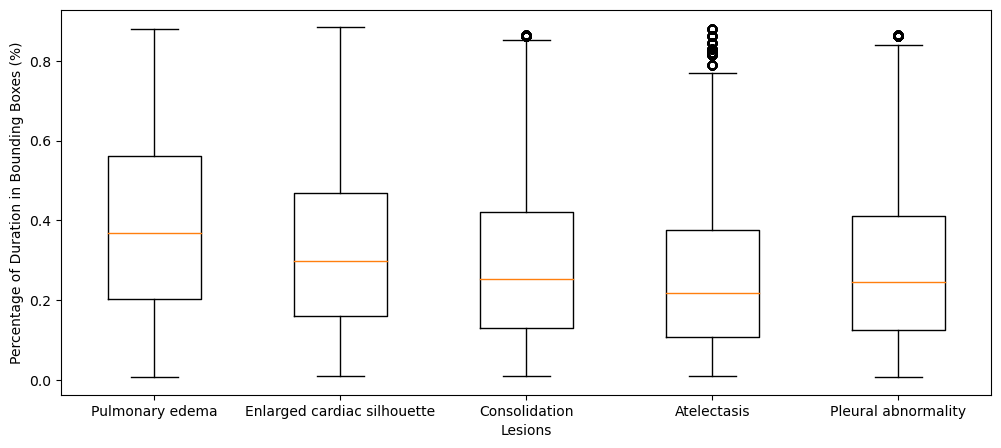

In [9]:
boxplot_generate(lesion_dur=lesion_dur, mode="silent")

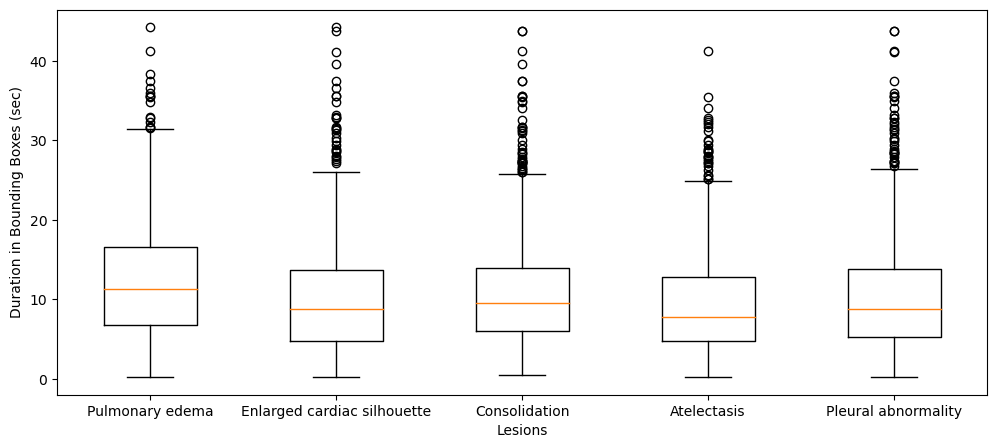

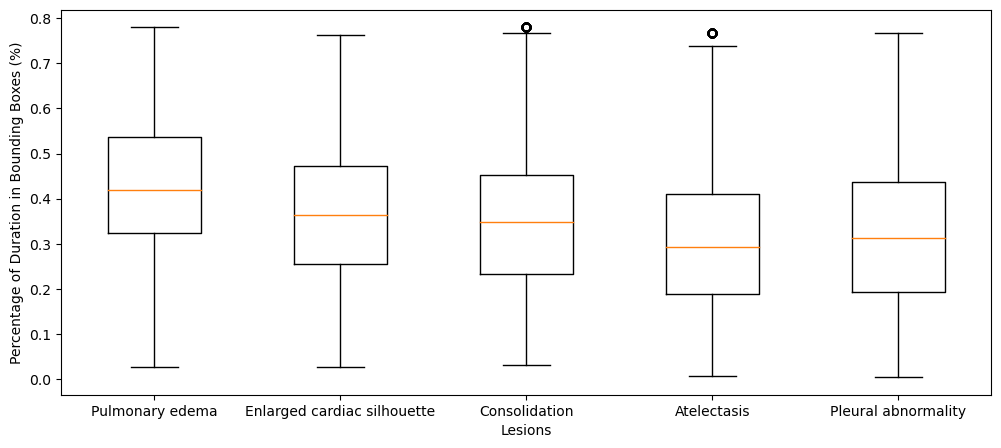

In [10]:
boxplot_generate(lesion_dur=lesion_dur, mode="reporting")